# General Linear Model

General linear models (GLMs) are a category of models that is commonly used in neuroimaging data analysis.
It is typically used to model how a variable (e.g., neural responses of a vertex) changes with a set of regressors (e.g., stimulus presentations).

In this example, we will use the object category localizer data from the [StudyForrest](https://www.studyforrest.org/) dataset.
In each run, the participant watched images of six categories: faces, scenes, bodies, houses, objects, and scrambled objects.

The tutorial will focus on the first run of the first participant.
We will examine which part of the brain responds to a given category, and which part of the brain responds **selectively** to a given category.

First, let's import all the packages we need:

In [36]:
%%capture
%pip install -U neuroboros

In [1]:
import urllib3
from io import StringIO

import matplotlib.pyplot as plt
import neuroboros as nb
import numpy as np
import pandas as pd
from scipy.stats import gamma, zscore
from scipy.ndimage import convolve1d

## Experimental design

The dataset is available as an [OpenNeuro Dataset](https://openneuro.org/datasets/ds000113).

For each localizer run, there is a NIFTI file (ends with `.nii` or `.nii.gz`) which is the fMRI data, and a TSV file (`.tsv`), which describes the design of the run.

For example, here are the [NIFTI file](https://openneuro.org/datasets/ds000113/versions/1.3.0/file-display/sub-01:ses-localizer:func:sub-01_ses-localizer_task-objectcategories_run-1_bold.nii.gz) and the [TSV file](https://openneuro.org/datasets/ds000113/versions/1.3.0/file-display/sub-01:ses-localizer:func:sub-01_ses-localizer_task-objectcategories_run-1_events.tsv) of the first localizer run.

We can use the `read_csv` function of the `pandas` package to load the TSV file:

In [2]:
url = 'https://openneuro.org/crn/datasets/ds000113/objects/'\
      '4a71014ac9ebeeddace74d0ec8164204869bc1d6'
resp = urllib3.request('GET', url)
assert resp.status == 200

In [3]:
content = StringIO(resp.data.decode('utf-8'))
df = pd.read_csv(content, sep='\t')

In the file, each block/trial is described using three attributes:
- **onset** (When did the block start relative to the start of the scan),
- **duration** (How long did the block last), and
- **trial_type** (What was the condition/stimulus type of the block).

In [4]:
df

,onset,duration,trial_type
0,11.995,16,face
1,35.988,16,scene
2,59.996,16,body
3,83.989,16,house
4,107.997,16,object
5,131.989,16,scramble
6,155.998,16,scramble
7,179.990,16,body
8,203.999,16,object
9,227.991,16,face


For the data we are going to use, the repetition time (TR) is 2 seconds, and each run contains 156 time points (TRs).

In [5]:
TR = 2.0
nt = 156

We subdivide each TR into 256 smaller time points for a higher temporal precision.

In [6]:
n_div = 256

In [7]:
t = np.arange(nt * n_div) * TR / n_div

Based on the design we got from the TSV file, we know when a block started and ended.

By aggregating across all blocks of the same type, we know when the stimulus category was presented to the participant or not at any given time point.

In [8]:
blocks = df[df['trial_type'] == 'face']
regressor = np.zeros_like(t)
for i in range(blocks.shape[0]):
    block = blocks.iloc[i]
    onset = block['onset']
    offset = onset + block['duration']
    print(f"Block onset: {onset:6.2f} s, Block offset: {offset:6.2f} s")
    regressor[np.logical_and(t > onset, t < offset)] = 1.0

Block onset:  11.99 s, Block offset:  27.99 s
Block onset: 227.99 s, Block offset: 243.99 s


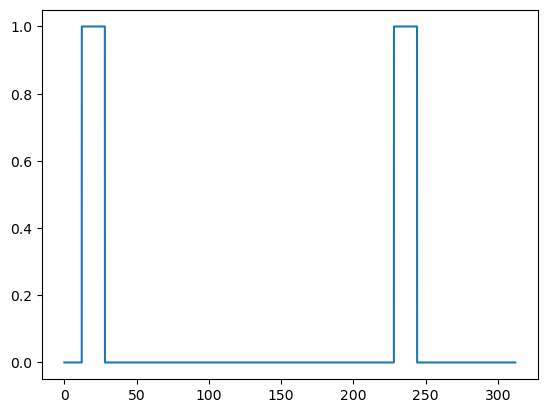

In [9]:
plt.plot(t, regressor)
plt.show()

Here are the boxcar regressors for all stimulus categories:

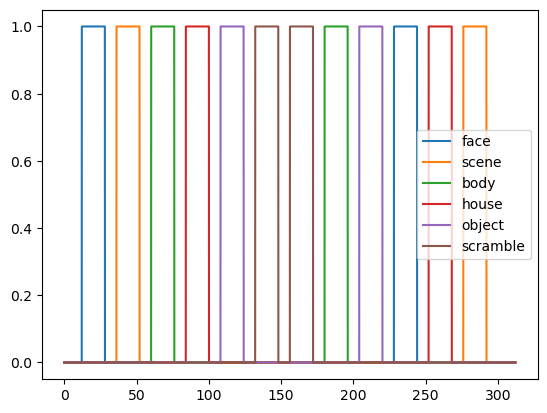

In [10]:
conditions = ['face', 'scene', 'body', 'house', 'object', 'scramble']
original_regressors = []
for condition in conditions:
    blocks = df[df['trial_type'] == condition]
    regressor = np.zeros_like(t)
    for i in range(blocks.shape[0]):
        block = blocks.iloc[i]
        onset = block['onset']
        offset = onset + block['duration']
        regressor[np.logical_and(t > onset, t < offset)] = 1.0
    original_regressors.append(regressor)
    plt.plot(t, regressor, label=condition)
plt.legend()
plt.show()

## Haemodynamic response function and convolution

To account for the haemodynamic response function (HRF), we will need to convolve these regressors.
Here we will use the HRF from SPM5, which was used by [Mantini et al., 2012](https://doi.org/10.1038/nmeth.1868) and shown in its
[Supplementary Figure 1](https://static-content.springer.com/esm/art%3A10.1038%2Fnmeth.1868/MediaObjects/41592_2012_BFnmeth1868_MOESM189_ESM.pdf).

The HRF is the difference between two Gamma functions, one for the main response and the other for the undershoot.

In [11]:
tt = np.arange(15 * n_div) * TR / n_div
bold = gamma.pdf(tt, 6) - gamma.pdf(tt, 16) / 6.0
bold /= bold.sum()

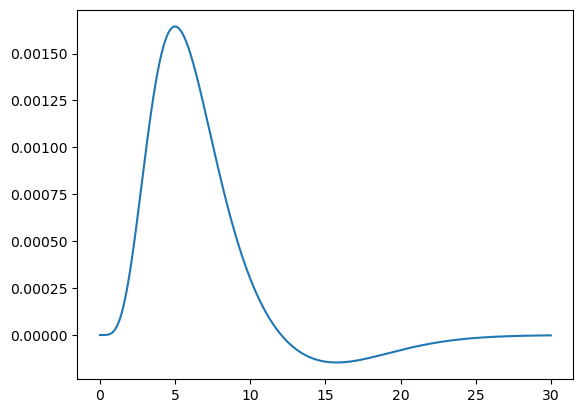

In [12]:
plt.plot(tt, bold)
plt.show()

Now we use the HRF to convolve our regressors:

In [13]:
kwargs = {"mode": "nearest", "origin": -len(bold) // 2}
convolved = []
for reg in original_regressors:
    reg = convolve1d(reg, bold, axis=0, **kwargs)
    convolved.append(reg)

After convolution, the regressors correctly reflect the haemodynamic delay:

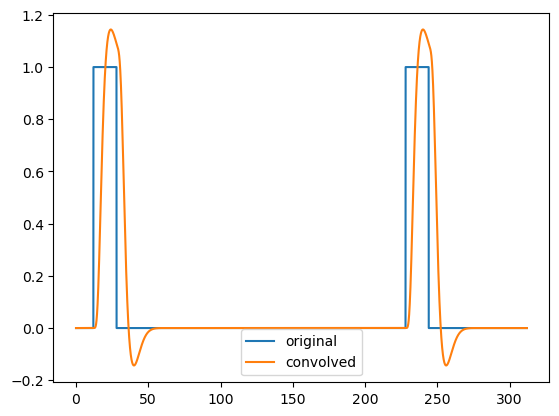

In [14]:
plt.plot(t, original_regressors[0], label='original')
plt.plot(t, convolved[0], label='convolved')
plt.legend()
plt.show()

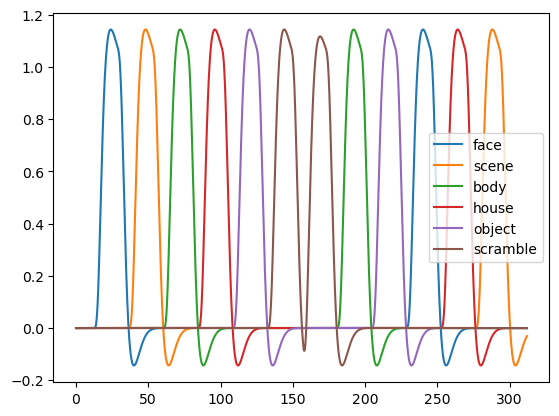

In [15]:
for condition, regressor in zip(conditions, convolved):
    plt.plot(t, regressor, label=condition)
plt.legend()
plt.show()

## Pairing regressors with fMRI data

The regressors we use have higher temporal resolution.
Here we downsample them to match our fMRI data.

In [16]:
regressors = []
for reg in convolved:
    downsampled = reg.reshape(-1, n_div).mean(axis=1)
    regressors.append(downsampled)
regressors = np.stack(regressors, axis=1)

The fMRI data have been preprocessed with fMRIPrep and curated using neuroboros.

In [17]:
dset = nb.Forrest()
sids = dset.subjects
sid = sids[0]

Besides the data matrix, we also have the confounding variables (aka nuisance regressors) from fMRIPrep.

In [18]:
dm = dset.load_data(
    sid, 'objectcategories', 1, 'lr',
    'onavg-ico32', dset.surface_resample)
confounds = dset.load_confounds(sid, 'objectcategories', 1)

In [19]:
reg.shape, regressors.shape, dm.shape, confounds[0].shape

((39936,), (156, 6), (156, 20484), (156, 22))

In [20]:
confounds[0]

array([[-0.06436624, -0.09735048,  0.05634564, ...,  1.        ,
        -1.        ,  1.        ],
       [ 0.00996179, -0.05005741, -0.05963685, ...,  1.        ,
        -0.98709677,  0.96154006],
       [ 0.0916715 , -0.03550841,  0.20058609, ...,  1.        ,
        -0.97419355,  0.9235796 ],
       ...,
       [-0.09220897, -0.03032143,  0.00818588, ...,  1.        ,
         0.97419355,  0.9235796 ],
       [-0.01562807, -0.09659374,  0.05209395, ...,  1.        ,
         0.98709677,  0.96154006],
       [ 0.12948981,  0.01547053,  0.04359279, ...,  1.        ,
         1.        ,  1.        ]])

In [21]:
confounds[1]

,global_signal,global_signal_derivative1,global_signal_power2,global_signal_derivative1_power2,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,...,rot_x_power2,rot_x_derivative1_power2,rot_y,rot_y_derivative1,rot_y_power2,rot_y_derivative1_power2,rot_z,rot_z_derivative1,rot_z_derivative1_power2,rot_z_power2
0,292.435067,NaN,85518.268259,NaN,396.300730,NaN,157054.268405,NaN,313.936551,NaN,...,5.041148e-06,NaN,0.000101,NaN,1.014895e-08,NaN,0.000000e+00,NaN,NaN,0.000000e+00
1,292.718334,0.283267,85684.023107,0.080240,396.542604,0.241874,157246.036838,0.058503,314.475375,0.538824,...,2.927624e-06,2.853910e-07,-0.000000,-0.000101,0.000000e+00,1.014895e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,292.599236,-0.119098,85614.312671,0.014184,397.557162,1.014558,158051.696889,1.029327,314.805351,0.329976,...,4.471575e-06,1.628768e-07,-0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,292.478735,-0.120501,85543.810359,0.014520,397.155322,-0.401840,157732.349869,0.161475,313.778681,-1.026670,...,2.371076e-06,3.303720e-07,-0.000095,-0.000095,9.078431e-09,9.078431e-09,-5.293960e-23,-5.293960e-23,2.802601e-45,2.802601e-45
4,291.915179,-0.563556,85214.471729,0.317595,396.402329,-0.752993,157134.806478,0.566999,313.849771,0.071090,...,2.661629e-06,8.394224e-09,-0.000180,-0.000084,3.228957e-08,7.125420e-09,0.000000e+00,5.293960e-23,2.802601e-45,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,292.969152,-0.309593,85830.923750,0.095848,398.315568,1.822215,158655.292049,3.320469,314.812829,0.631811,...,7.688273e-07,1.033700e-07,0.000705,0.000000,4.966542e-07,0.000000e+00,-1.532280e-04,-9.853670e-05,9.709481e-09,2.347882e-08
152,293.315032,0.345881,86033.708032,0.119633,397.179822,-1.135747,157751.810807,1.289921,314.350860,-0.461968,...,1.502855e-06,1.218582e-07,0.000705,0.000000,4.966542e-07,0.000000e+00,-1.532280e-04,0.000000e+00,0.000000e+00,2.347882e-08
153,293.217327,-0.097705,85976.400942,0.009546,397.896884,0.717062,158321.930014,0.514178,315.146570,0.795710,...,8.663216e-07,8.711116e-08,0.001006,0.000301,1.011513e-06,9.060281e-08,-1.532280e-04,0.000000e+00,0.000000e+00,2.347882e-08
154,293.250529,0.033202,85995.872768,0.001102,396.355571,-1.541313,157097.738436,2.375646,314.618423,-0.528147,...,6.301708e-07,1.875010e-08,0.000909,-0.000096,8.267774e-07,9.305882e-09,-1.532280e-04,0.000000e+00,0.000000e+00,2.347882e-08


In [22]:
confounds[2]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## Visualizing regressors

In [23]:
R = np.concatenate([regressors, confounds[0]], axis=1)

In [24]:
mat = np.corrcoef(R.T)

/Users/feilong/miniconda3/envs/nb/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/feilong/miniconda3/envs/nb/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


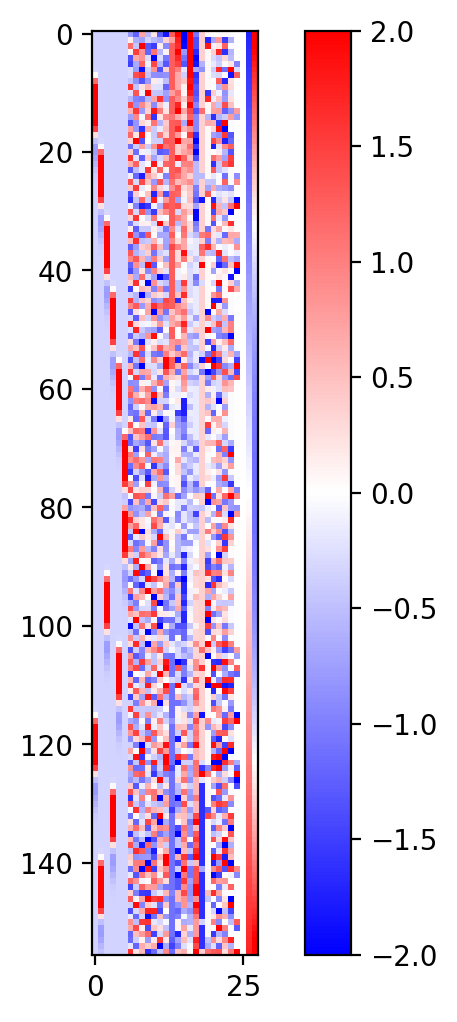

In [25]:
fig = plt.figure(figsize=(6, 6), dpi=200)
plt.imshow(zscore(R, axis=0), vmax=2, vmin=-2, cmap='bwr')
plt.colorbar()
plt.show()

## Correlation among regressors

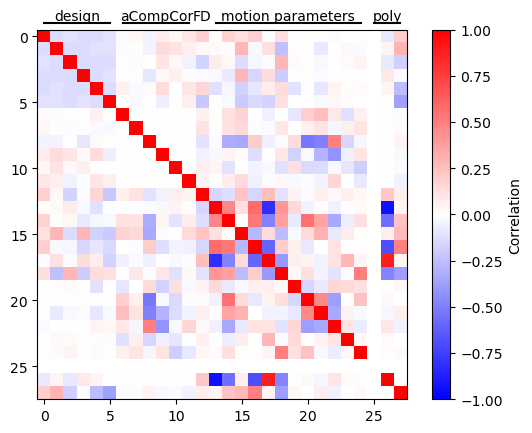

In [26]:
plt.imshow(mat, vmax=1, vmin=-1, cmap='bwr')
plt.plot((0, 5), (-1, -1), 'k-', clip_on=False)
plt.annotate('design', (2.5, -1), annotation_clip=False, ha='center', va='bottom')
plt.plot((6, 11), (-1, -1), 'k-', clip_on=False)
plt.annotate('aCompCor', (8.5, -1), annotation_clip=False, ha='center', va='bottom')
plt.annotate('FD', (12, -1), annotation_clip=False, ha='center', va='bottom')
plt.plot((13, 24), (-1, -1), 'k-', clip_on=False)
plt.annotate('motion parameters', (18.5, -1), annotation_clip=False, ha='center', va='bottom')
plt.plot((25, 27), (-1, -1), 'k-', clip_on=False)
plt.annotate('poly', (26, -1), annotation_clip=False, ha='center', va='bottom')
plt.ylim([mat.shape[0] - 0.5, -0.5])
plt.colorbar(label='Correlation')
plt.show()

## General Linear Model

In [27]:
beta_conf = np.linalg.lstsq(confounds[0], dm, rcond=None)[0]
denoised = dm - confounds[0] @ beta_conf
denoised = np.nan_to_num(zscore(denoised, axis=0))

In [28]:
betas, ts, R2s = nb.glm(
    denoised, regressors, confounds[0], return_r2=True)

/Users/feilong/miniconda3/envs/nb/lib/python3.12/site-packages/neuroboros/glm.py:65: RuntimeWarning: divide by zero encountered in divide
  ratio = np.sqrt(mid) / sigma
/Users/feilong/miniconda3/envs/nb/lib/python3.12/site-packages/neuroboros/glm.py:67: RuntimeWarning: invalid value encountered in multiply
  t = R_beta * ratio
/Users/feilong/miniconda3/envs/nb/lib/python3.12/site-packages/neuroboros/glm.py:81: RuntimeWarning: invalid value encountered in divide
  R2s = 1 - ss_res * dof_all / (ss_all * dof_res)


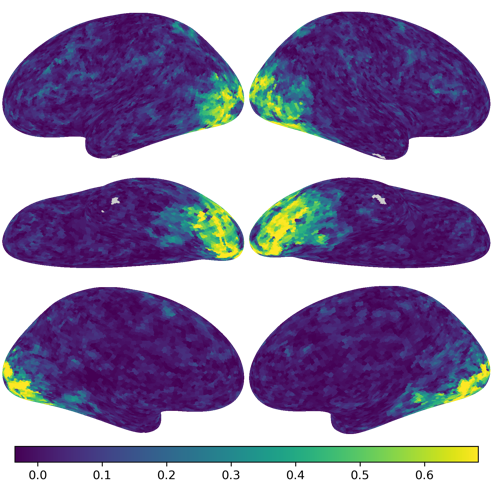

In [29]:
nb.plot(R2s)

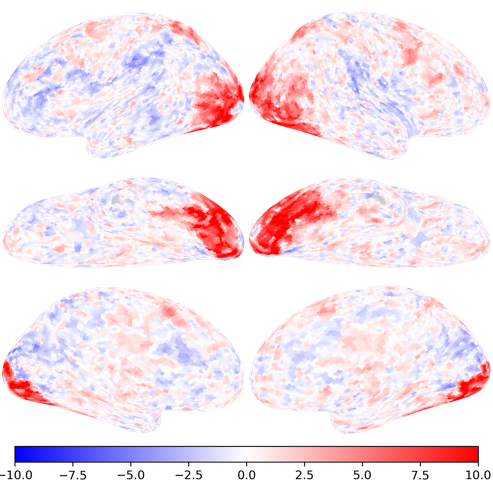

In [30]:
nb.plot(ts[conditions.index('face')], vmax=10, vmin=-10, cmap='bwr')

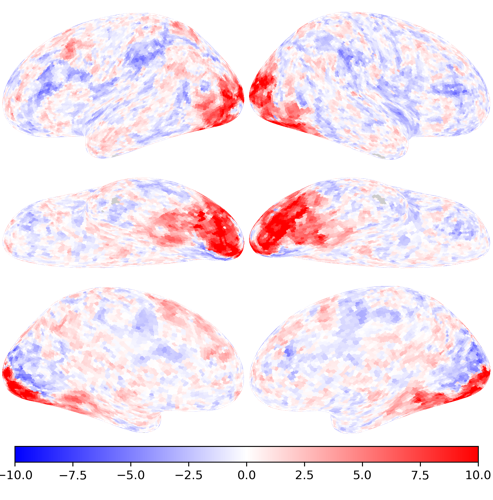

In [31]:
nb.plot(ts[conditions.index('house')], vmax=10, vmin=-10, cmap='bwr')

## Category-selective responses

In [32]:
# ['face', 'scene', 'body', 'house', 'object', 'scramble']
contrasts = [
    [ 5, -1, -1, -1, -1, -1],  # face vs. others
    [-1,  2, -1,  2, -1, -1],  # scene/house vs. others
]

In [33]:
betas, ts, R2s = nb.glm(
    denoised, regressors, confounds[0], contrasts=contrasts, return_r2=True)

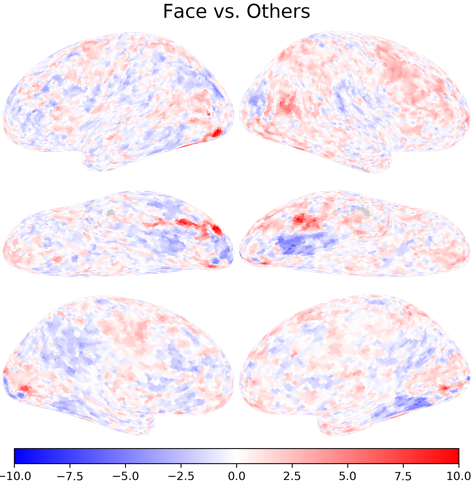

In [34]:
nb.plot(ts[0], vmax=10, vmin=-10, cmap='bwr', title='Face vs. Others')

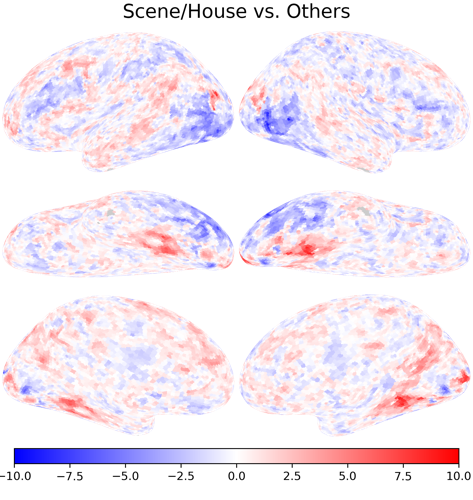

In [35]:
nb.plot(ts[1], vmax=10, vmin=-10, cmap='bwr', title='Scene/House vs. Others')